In [58]:
# GNN and Tabular Transformer (Address-level)
# Single-file notebook-style script using cell separators (for Jupyter/VSCode: Run cells)
# This version is tailored for the provided file: /mnt/data/ethereum_raw.csv
# It assumes the file is already address-level with columns: 'Address' (ID) and 'FLAG' (label).
# The notebook will: load data, preprocess, build a KNN similarity graph for GNN, train a node-classifier GNN and a Tabular Transformer, evaluate and save artifacts.


In [59]:
# 1) Setup & imports

# Standard library imports
import os                     # filesystem operations (paths, mkdir)
import random                 # pseudo-random utilities (seed, random)
import pickle                 # serialization for saving/loading Python objects

# Data science / numeric libraries
import numpy as np            # numerical arrays and operations
import pandas as pd           # tabular data handling (DataFrame)

# PyTorch (deep learning)
import torch                  # core PyTorch (tensors, device handling, random seeds)
import torch.nn as nn         # neural network building blocks (modules, layers)
import torch.nn.functional as F  # functional forms of common layers / losses

# Scikit-learn utilities for preprocessing, splitting and evaluation
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,                  # AUC-ROC metric
    precision_recall_curve,        # precision-recall curve helper
    auc,                           # area under curve helper (used for PR AUC)
    precision_recall_fscore_support,# detailed precision/recall/fscore per class
    accuracy_score                 # simple accuracy metric
)
from sklearn.neighbors import NearestNeighbors  # for computing nearest neighbors (graph construction / overlap checks)

# Optional: PyTorch Geometric (graph neural network utilities)
# Wrapped in try/except because not all environments have torch_geometric installed.
try:
    import torch_geometric
    from torch_geometric.data import Data   # container for graph data (node features, edge index, labels)
    from torch_geometric.nn import SAGEConv # GraphSAGE convolution layer (used for GNN)
except Exception as e:
    # If import fails, print a clear message but allow the notebook to continue (we might only run baselines).
    print("torch_geometric not installed or import failed:", e)

# Optional: LightGBM for baseline gradient-boosted trees
# Wrapped in try/except so notebook still runs even if lightgbm is missing.
try:
    import lightgbm as lgb
except Exception:
    lgb = None  # mark as unavailable — downstream code should check this before using LightGBM

# Reproducibility: fix random seeds for Python, NumPy and PyTorch
SEED = 42
random.seed(SEED)        # seed Python's random
np.random.seed(SEED)     # seed NumPy's RNG
# If CUDA is available, also set CUDA seeds and deterministic flags to reduce nondeterminism
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # Force deterministic convolution algorithms (may slow training but improves reproducibility)
    torch.backends.cudnn.deterministic = True
    # Disable benchmark to prevent nondeterministic algorithm selection
    torch.backends.cudnn.benchmark = False

# Paths and artifacts
DATA_PATH = 'E:/Projects/CBK_Assignment/Greenland_Registry/ethereum_raw.csv'  # raw CSV dataset path
ARTIFACTS_DIR = './artifacts'  # directory to store outputs (models, processed data, logs)
os.makedirs(ARTIFACTS_DIR, exist_ok=True)  # create artifacts directory if it doesn't exist


In [60]:
# 2) Load CSV & quick EDA (Exploratory Data Analysis)

# Print which file is being loaded for clarity
print('Loading', DATA_PATH)

# Load the Ethereum dataset from the specified CSV file path into a pandas DataFrame
df = pd.read_csv(DATA_PATH)

# Display the number of rows (samples) and columns (features) to understand dataset size
print('Rows, cols:', df.shape)

# Print the list of all column names to get an overview of available features
print(df.columns.tolist())

# Show the first 3 rows of the dataset to visually inspect structure, datatypes, and example values
print(df.head(3))


Loading E:/Projects/CBK_Assignment/Greenland_Registry/ethereum_raw.csv
Rows, cols: (9841, 51)
['Unnamed: 0', 'Index', 'Address', 'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 avg time between 

In [61]:
# 3) Remove leaking or redundant index-like columns

# Some CSV exports (especially from pandas) include an extra "Unnamed: 0" or "Index" column 
# that simply duplicates the row index — this can leak information during model training.
# The following code checks for such columns and drops them if they exist.

if 'Unnamed: 0' or 'Index' in df.columns:
    # Drop both columns if present; errors='ignore' ensures no error is raised if not found
    df = df.drop(columns=['Unnamed: 0', 'Index'], errors='ignore')

# Display the first 5 rows again to confirm that unwanted columns are removed
df.head(5)


,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [62]:
# # 4) Train/validation/test split + preprocessing (fit transformers on TRAIN only)

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# import pickle, numpy as np, os

# # Assumptions: df is already loaded, contains columns 'Address' and 'FLAG'
# # If your notebook had explicit lists for numeric/categorical columns, reuse them.
# # Otherwise auto-detect:
# # Build feature list by excluding identifier/target-like columns
# feature_cols = [c for c in df.columns if c not in ('Address', 'FLAG', 'flag', 'Label', 'label')]
# addresses = df['Address'].values               # keep original addresses (for later mapping / graph construction)
# y = df['FLAG'].values                           # target labels array

# # crude split of categorical vs numeric (you can override lists if you had custom lists)
# # Treat columns as categorical if dtype==object OR they have low cardinality (<50 unique values)
# categorical_cols = [c for c in feature_cols if df[c].dtype == 'object' or df[c].nunique() < 50]
# numeric_cols = [c for c in feature_cols if c not in categorical_cols]  # remaining considered numeric
# print(numeric_cols)
# print(categorical_cols)
# # INDEX-BASED SPLIT (stratified to preserve class balance)
# idx = np.arange(len(df))  # array of row indices
# # Hold out 20% for final test set, stratifying by the label y to keep class proportions
# train_idx, test_idx = train_test_split(idx, test_size=0.20, random_state=SEED, stratify=y)
# # From the remaining training indices, split a validation set (15% of the original train indices)
# train_idx, val_idx  = train_test_split(train_idx, test_size=0.15, random_state=SEED, stratify=y[train_idx])
# print(f"Split sizes: train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")

# # Prepare raw column-wise DataFrames for convenience (we will transform these)
# X_raw_num = df[numeric_cols].copy()   # numeric features (may contain NaNs)
# X_raw_cat = df[categorical_cols].copy()# categorical features (strings / low-cardinality values)

# # --- Fit transformers ON TRAIN ONLY --- (important: avoid leakage from validation/test)
# # 1) LabelEncoders for categorical columns
# cat_encoders = {}  # will store fitted label encoders + mapping + unknown index per column
# # Preallocate an integer array to hold encoded categorical values for all rows
# X_cat = np.empty((len(df), len(categorical_cols)), dtype=np.int32)
# for i, col in enumerate(categorical_cols):
#     le = LabelEncoder()
#     # Replace missing values with a sentinel token and convert to string before fitting
#     train_vals = X_raw_cat.iloc[train_idx][col].fillna("<<NA>>").astype(str)
#     le.fit(train_vals)  # fit only on training values to avoid leakage
#     # Create a mapping from observed category value -> integer index
#     mapping = {v: idx_ for idx_, v in enumerate(le.classes_)}
#     unk_index = len(mapping)  # reserve a new index for unseen categories in val/test
#     # Apply mapping to all rows safely: map known values, unseen values -> unk_index
#     X_cat[:, i] = X_raw_cat[col].fillna("<<NA>>").astype(str).map(lambda x: mapping.get(x, unk_index)).values
#     # Save encoder info so we can inverse-transform or reuse later
#     cat_encoders[col] = {"label_encoder": le, "mapping": mapping, "unk_index": unk_index}

# # 2) StandardScaler for numeric columns (fit on train numeric only)
# scaler = StandardScaler()
# # Fill NaNs with 0 for fitting (simple imputation). Important: fit on train rows only.
# scaler.fit(X_raw_num.iloc[train_idx].fillna(0).values)

# # transform numeric features for all rows using the fitted scaler (same imputation strategy)
# X_num_scaled = scaler.transform(X_raw_num.fillna(0).values)

# # --- Build final X arrays (concatenate numeric + encoded categorical) ---
# # Cast categorical encodings to float and hstack with scaled numeric features for model compatibility
# X_all = np.hstack([X_num_scaled, X_cat.astype(float)])   # final feature matrix (rows x features)

# # split into train/val/test arrays using previously computed indices
# X_train = X_all[train_idx]
# X_val   = X_all[val_idx]
# X_test  = X_all[test_idx]

# y_train = y[train_idx]
# y_val   = y[val_idx]
# y_test  = y[test_idx]

# # Also split addresses so we can map back predictions to original entities later
# addresses_train = addresses[train_idx]
# addresses_val   = addresses[val_idx]
# addresses_test  = addresses[test_idx]

# # drop = ['suspect_col1','suspect_col2']
# # X_train = X_train.drop(columns=drop).values  # adapt to your code if you need to remove columns after building X

# print("Feature count:", X_all.shape[1])

# # Save artifacts (scalers/encoders + splits) so downstream cells use train-fitted objects
# os.makedirs(ARTIFACTS_DIR, exist_ok=True)
# with open(os.path.join(ARTIFACTS_DIR, "preproc_train_encoders.pkl"), "wb") as f:
#     # Persist column lists, encoders, and the scaler so later cells (or other runs) can load and reproduce transforms
#     pickle.dump({"categorical_cols": categorical_cols,
#                  "numeric_cols": numeric_cols,
#                  "cat_encoders": cat_encoders,
#                  "scaler": scaler,
#                  "feature_cols": feature_cols}, f)

# # Save numpy splits used by later cells for quick loading (avoids re-running preprocessing)
# np.save(os.path.join(ARTIFACTS_DIR, "X_train.npy"), X_train)
# np.save(os.path.join(ARTIFACTS_DIR, "X_val.npy"), X_val)
# np.save(os.path.join(ARTIFACTS_DIR, "X_test.npy"), X_test)
# np.save(os.path.join(ARTIFACTS_DIR, "y_train.npy"), y_train)
# np.save(os.path.join(ARTIFACTS_DIR, "y_val.npy"), y_val)
# np.save(os.path.join(ARTIFACTS_DIR, "y_test.npy"), y_test)
# np.save(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), addresses_train)
# np.save(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), addresses_val)
# np.save(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), addresses_test)

# print("Saved train-only preproc artifacts to", ARTIFACTS_DIR)
# # ----- END REPLACEMENT BLOCK -----


In [63]:
# Replacement block: dedupe addresses, 80/20 group-aware split, train-only preprocessing, feature lists + checks

from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np, pandas as pd, os, pickle, scipy.stats as stats

# --- Config defaults (override if already set) ---
SEED = globals().get("SEED", 42)
ARTIFACTS_DIR = globals().get("ARTIFACTS_DIR", "./artifacts")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# --- 0) Sanity checks ---
assert 'Address' in df.columns, "DataFrame must contain an 'Address' column"
assert 'FLAG' in df.columns, "DataFrame must contain a 'FLAG' column"

# --- 1) Detect duplicate addresses and resolve them ---
addr_counts = df['Address'].value_counts()
n_duplicates = (addr_counts > 1).sum()
print(f"Unique addresses: {df['Address'].nunique()}, Addresses with >1 row: {n_duplicates}")

if n_duplicates == 0:
    print("No duplicate addresses found — skipping deduplication.")
    df_dedup = df.copy()
else:
    print("Performing group-wise deduplication (numeric: mean, categorical: mode).")
    # choose feature columns (exclude identifiers/targets)
    exclude_cols = {'Address', 'FLAG', 'flag', 'Label', 'label'}
    feature_cols = [c for c in df.columns if c not in exclude_cols]

    # identify numeric / categorical heuristically
    categorical_cols = [c for c in feature_cols if df[c].dtype == 'object' or df[c].nunique() < 50]
    numeric_cols = [c for c in feature_cols if c not in categorical_cols]

    # group by Address and perform aggregation
    groups = df.groupby('Address')

    agg_frames = []
    dropped_addresses = []
    for addr, g in groups:
        flags = g['FLAG'].astype(int).values
        # if all flags equal -> keep that label
        if np.all(flags == flags[0]):
            resolved_flag = int(flags[0])
        else:
            # majority vote
            vals, counts = np.unique(flags, return_counts=True)
            max_count = counts.max()
            winners = vals[counts == max_count]
            if len(winners) == 1:
                resolved_flag = int(winners[0])
            else:
                # tie -> skip this address to avoid noisy label
                dropped_addresses.append(addr)
                continue

        # aggregate numeric features (mean)
        if numeric_cols:
            num_row = g[numeric_cols].astype(float).mean(axis=0)
        else:
            num_row = pd.Series(dtype=float)

        # aggregate categorical features (mode) with fallback to first non-null
        cat_row_vals = {}
        for c in categorical_cols:
            mode_val = None
            try:
                mode_series = g[c].dropna().astype(str)
                if len(mode_series) == 0:
                    mode_val = np.nan
                else:
                    mode_val = mode_series.mode().iat[0]
            except Exception:
                mode_val = g[c].astype(str).iloc[0]  # fallback
            cat_row_vals[c] = mode_val

        # build aggregated row
        row = {"Address": addr, "FLAG": resolved_flag}
        row.update(num_row.to_dict())
        row.update(cat_row_vals)
        agg_frames.append(row)

    df_dedup = pd.DataFrame(agg_frames).reset_index(drop=True)
    print(f"Dedup completed. Original rows: {len(df)}, After dedup rows: {len(df_dedup)}")
    if dropped_addresses:
        print(f"Dropped {len(dropped_addresses)} addresses due to tie in FLAG (to avoid label noise).")
    # Recompute feature lists to be safe
    feature_cols = [c for c in df_dedup.columns if c not in ('Address','FLAG')]
    categorical_cols = [c for c in feature_cols if df_dedup[c].dtype == 'object' or df_dedup[c].nunique() < 50]
    numeric_cols = [c for c in feature_cols if c not in categorical_cols]

# If no duplicates happened earlier, ensure feature lists are present
if 'feature_cols' not in locals():
    feature_cols = [c for c in df_dedup.columns if c not in ('Address','FLAG')]
    categorical_cols = [c for c in feature_cols if df_dedup[c].dtype == 'object' or df_dedup[c].nunique() < 50]
    numeric_cols = [c for c in feature_cols if c not in categorical_cols]

print("Final feature counts -> total:", len(feature_cols), "numeric:", len(numeric_cols), "categorical:", len(categorical_cols))

# --- 2) Group-aware 80/20 split (ensures no address leakage) ---
X_df = df_dedup.copy()
y_all = X_df['FLAG'].values
groups = X_df['Address'].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
train_idx, test_idx = next(gss.split(X_df, y_all, groups=groups))

print(f"Split sizes (group-aware 80/20): train={len(train_idx)}, test={len(test_idx)} (total {len(X_df)})")

# Secondary validation split from train (optional; ~15% of train as validation)
# If you need an explicit val split, you can do a stratified split within train (without breaking groups).
# Here we'll create a small validation set by GroupShuffleSplit on the training subset:
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
train_idx_sub = train_idx
# Note: groups for gss2 must be the subset groups
train_groups = groups[train_idx_sub]
sub_train_idx_relative, val_idx_relative = next(gss2.split(np.arange(len(train_idx_sub)), y_all[train_idx_sub], groups=train_groups))
# map relative indices back to global indices
val_idx = train_idx_sub[val_idx_relative]
train_idx = np.delete(train_idx_sub, val_idx_relative)

print(f"After creating val: train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")

# --- Safety check: ensure no address overlap between train and test/val ---
addr_train = set(groups[train_idx])
addr_val   = set(groups[val_idx])
addr_test  = set(groups[test_idx])

overlap_train_test = addr_train & addr_test
overlap_train_val  = addr_train & addr_val
overlap_val_test   = addr_val & addr_test

assert len(overlap_train_test) == 0, f"Address overlap between train and test found: {len(overlap_train_test)}"
assert len(overlap_train_val) == 0, f"Address overlap between train and val found: {len(overlap_train_val)}"
assert len(overlap_val_test) == 0, f"Address overlap between val and test found: {len(overlap_val_test)}"

print("No address overlap across splits (group constraint honored).")

# --- 3) Prepare raw column-wise DataFrames for convenience (we will transform these) ---
X_raw_num = X_df[numeric_cols].copy()   # numeric features (may contain NaNs)
X_raw_cat = X_df[categorical_cols].copy()# categorical features (strings / low-cardinality values)
addresses = X_df['Address'].values
y = X_df['FLAG'].astype(int).values

# --- 4) Fit transformers ON TRAIN ONLY (LabelEncoders + StandardScaler) ---
cat_encoders = {}
X_cat = np.empty((len(X_df), len(categorical_cols)), dtype=np.int32) if categorical_cols else np.empty((len(X_df), 0))

for i, col in enumerate(categorical_cols):
    le = LabelEncoder()
    train_vals = X_raw_cat.iloc[train_idx][col].fillna("<<NA>>").astype(str)
    le.fit(train_vals)
    mapping = {v: idx_ for idx_, v in enumerate(le.classes_)}
    unk_index = len(mapping)
    # apply mapping to all rows
    mapped = X_raw_cat[col].fillna("<<NA>>").astype(str).map(lambda x: mapping.get(x, unk_index)).values
    X_cat[:, i] = mapped
    cat_encoders[col] = {"label_encoder": le, "mapping": mapping, "unk_index": unk_index}

# 2) StandardScaler for numeric columns (fit on train numeric only)
scaler = StandardScaler()
if len(numeric_cols) > 0:
    scaler.fit(X_raw_num.iloc[train_idx].fillna(0).values)
    X_num_scaled = scaler.transform(X_raw_num.fillna(0).values)
else:
    X_num_scaled = np.zeros((len(X_df), 0))

# --- Build final X arrays (concatenate numeric + encoded categorical) ---
# Cast categorical encodings to float and hstack with scaled numeric features
if X_cat.shape[1] == 0:
    X_all = X_num_scaled
else:
    X_all = np.hstack([X_num_scaled, X_cat.astype(float)])

# split into train/val/test arrays using previously computed indices
X_train = X_all[train_idx]
X_val   = X_all[val_idx]
X_test  = X_all[test_idx]

y_train = y[train_idx]
y_val   = y[val_idx]
y_test  = y[test_idx]

addresses_train = addresses[train_idx]
addresses_val   = addresses[val_idx]
addresses_test  = addresses[test_idx]

print("Feature count (final):", X_all.shape[1])
print("Shapes -> X_train, X_val, X_test:", X_train.shape, X_val.shape, X_test.shape)
print("Label distribution (train/test):",
      dict(zip(*np.unique(y_train, return_counts=True))),
      dict(zip(*np.unique(y_test, return_counts=True))))

# --- 5) Extra safety check: do any *rows* (feature vectors) in train exactly match any in test? ---
# This is stricter than address overlap — it checks identical feature vectors
from sklearn.metrics import pairwise_distances
# We'll check for exact equality by hashing rows (fast)
def row_hashes(arr):
    # convert to bytes for each row and hash (use numpy's tostring/bytes)
    return [hash(bytes(row)) for row in arr.astype(np.float64).tobytes().split(b'')] if False else [hash(tuple(r)) for r in arr]

# safer explicit approach:
train_hashes = {hash(tuple(r)): idx for idx,r in enumerate(X_train)}
overlap_rows = []
for i, row in enumerate(X_test):
    h = hash(tuple(row))
    if h in train_hashes:
        # double-check exact equality (hash collision possible)
        if np.array_equal(row, X_train[train_hashes[h]]):
            overlap_rows.append((i, train_hashes[h]))

if len(overlap_rows) == 0:
    print("No identical feature-vector rows found between train and test.")
else:
    print(f"Found {len(overlap_rows)} identical rows between train and test. Example pairs (test_idx, train_idx):", overlap_rows[:5])
    # Optional: you can drop duplicates in test or re-split — choose policy as needed.

# --- 6) Save preproc artifacts and numpy splits (same as your original style) ---
with open(os.path.join(ARTIFACTS_DIR, "preproc_train_encoders.pkl"), "wb") as f:
    pickle.dump({"categorical_cols": categorical_cols,
                 "numeric_cols": numeric_cols,
                 "cat_encoders": cat_encoders,
                 "scaler": scaler,
                 "feature_cols": feature_cols}, f)

np.save(os.path.join(ARTIFACTS_DIR, "X_train.npy"), X_train)
np.save(os.path.join(ARTIFACTS_DIR, "X_val.npy"), X_val)
np.save(os.path.join(ARTIFACTS_DIR, "X_test.npy"), X_test)
np.save(os.path.join(ARTIFACTS_DIR, "y_train.npy"), y_train)
np.save(os.path.join(ARTIFACTS_DIR, "y_val.npy"), y_val)
np.save(os.path.join(ARTIFACTS_DIR, "y_test.npy"), y_test)
np.save(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), addresses_train)
np.save(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), addresses_val)
np.save(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), addresses_test)

print("Saved train-only preproc artifacts to", ARTIFACTS_DIR)

# --- 7) Print the feature lists used in training and testing for quick reference ---
print("\n--- FEATURE LIST (final) ---")
print("Total features:", len(feature_cols))
print("Numeric cols (count={}):".format(len(numeric_cols)), numeric_cols[:50])
print("Categorical cols (count={}):".format(len(categorical_cols)), categorical_cols[:50])


Unique addresses: 9816, Addresses with >1 row: 25
Performing group-wise deduplication (numeric: mean, categorical: mode).
Dedup completed. Original rows: 9841, After dedup rows: 9816
Final feature counts -> total: 47 numeric: 31 categorical: 16
Split sizes (group-aware 80/20): train=7852, test=1964 (total 9816)
After creating val: train=6674, val=1178, test=1964
No address overlap across splits (group constraint honored).
Feature count (final): 47
Shapes -> X_train, X_val, X_test: (6674, 47) (1178, 47) (1964, 47)
Label distribution (train/test): {np.int64(0): np.int64(5199), np.int64(1): np.int64(1475)} {np.int64(0): np.int64(1534), np.int64(1): np.int64(430)}
Found 91 identical rows between train and test. Example pairs (test_idx, train_idx): [(53, 6641), (73, 6641), (89, 6672), (105, 6646), (140, 6672)]
Saved train-only preproc artifacts to ./artifacts

--- FEATURE LIST (final) ---
Total features: 47
Numeric cols (count=31): ['Avg min between sent tnx', 'Avg min between received tnx'

In [64]:
# FINAL LightGBM training cell (recommended)
# - Collapses rare categorical codes (train-only)
# - Trains with callbacks (early stopping + logging)
# - Evaluates on test
# - Optionally retrains final model on train+val for deployment

import os, pickle, numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, accuracy_score

ART = globals().get("ARTIFACTS_DIR", "./artifacts")
SEED = globals().get("SEED", 42)

# CONFIG
RARE_THRESHOLD = 50     # treat codes with < this many occurrences in TRAIN as 'OTHER' (tune if needed)
FINAL_TRAIN = False     # if True, after validation run, retrain on train+val using best_iter and save final booster
MODEL_OUT = os.path.join(ART, "lightgbm_booster_final.txt")

# --- load preproc artifact to get numeric/categorical col lists (must exist) ---
pkl_path = os.path.join(ART, "preproc_train_encoders.pkl")
assert os.path.exists(pkl_path), f"Missing {pkl_path} — run preprocessing first."
enc = pickle.load(open(pkl_path, "rb"))
numeric_cols = enc.get("numeric_cols", [])
categorical_cols = enc.get("categorical_cols", [])
print("Found numeric_cols:", len(numeric_cols), "categorical_cols:", len(categorical_cols))

# global index helper: numeric columns first, then categorical (matches X_all construction)
def global_index(cat_idx):
    return len(numeric_cols) + cat_idx

# --- load X/y splits ---
X_train = np.load(os.path.join(ART, "X_train.npy"))
X_val   = np.load(os.path.join(ART, "X_val.npy"))
X_test  = np.load(os.path.join(ART, "X_test.npy"))
y_train = np.load(os.path.join(ART, "y_train.npy"))
y_val   = np.load(os.path.join(ART, "y_val.npy"))
y_test  = np.load(os.path.join(ART, "y_test.npy"))

print("Shapes -> X_train, X_val, X_test:", X_train.shape, X_val.shape, X_test.shape)

# --- collapse rare categorical codes based on TRAIN only ---
X_tr = X_train.copy()
X_va = X_val.copy()
X_te = X_test.copy()

sanitized_cols = []
for ci, cname in enumerate(categorical_cols):
    gidx = global_index(ci)
    vals, counts = np.unique(X_tr[:, gidx], return_counts=True)
    rare_vals = set(vals[counts < RARE_THRESHOLD])
    if len(rare_vals) == 0:
        continue
    # choose a new integer code for the collapsed "OTHER" value (safe: max(train_vals)+1)
    new_code = int(vals.max() + 1)
    # replace rare codes in train/val/test
    mask_tr = np.isin(X_tr[:, gidx], list(rare_vals)); X_tr[mask_tr, gidx] = new_code
    mask_va = np.isin(X_va[:, gidx], list(rare_vals)); X_va[mask_va, gidx] = new_code
    mask_te = np.isin(X_te[:, gidx], list(rare_vals)); X_te[mask_te, gidx] = new_code
    sanitized_cols.append((gidx, cname, len(rare_vals)))
print("Sanitized categorical columns (global_idx, name, #rare_codes):", sanitized_cols)

# Optionally save a small artifact describing the sanitization so you can reproduce / debug later
try:
    with open(os.path.join(ART, "sanitization_info.pkl"), "wb") as f:
        pickle.dump({"sanitized_cols": sanitized_cols, "RARE_THRESHOLD": RARE_THRESHOLD}, f)
except Exception:
    pass

# --- LightGBM params (paper-like conservative values) ---
params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 10,
    'min_data_in_leaf': 100,
    'objective': 'binary',
    'metric': 'auc',
    'seed': SEED,
    'verbose': -1
}

# Build datasets and train with callbacks for compatibility
dtrain = lgb.Dataset(X_tr, label=y_train)
dval   = lgb.Dataset(X_va, label=y_val, reference=dtrain)

num_boost_round = 1000
early_stop = 50
verbose_eval = 50

bst = lgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(early_stop), lgb.log_evaluation(verbose_eval)]
)

best_iter = getattr(bst, "best_iteration", None) or num_boost_round
print("Best iteration chosen:", best_iter)

# --- Evaluate on test set ---
test_probs = bst.predict(X_te, num_iteration=best_iter)
test_pred = (test_probs > 0.5).astype(int)

test_auc = roc_auc_score(y_test, test_probs) if len(np.unique(y_test)) > 1 else float('nan')
test_ap  = average_precision_score(y_test, test_probs)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, test_pred, average='binary', zero_division=0)
acc = accuracy_score(y_test, test_pred)

print("\nLightGBM test metrics (sanitized):")
print(f"ROC-AUC: {test_auc:.6f}")
print(f"PR-AUC (AP): {test_ap:.6f}")
print(f"precision: {prec:.6f}, recall: {rec:.6f}, f1: {f1:.6f}, acc: {acc:.6f}")

# Save test artifacts and model
np.save(os.path.join(ART, "lightgbm_test_probs.npy"), test_probs)
np.save(os.path.join(ART, "lightgbm_test_preds.npy"), test_pred)
np.save(os.path.join(ART, "lightgbm_test_true.npy"), y_test)
bst.save_model(MODEL_OUT)
print("Saved booster to", MODEL_OUT)

# --- OPTIONAL: final production model trained on train+val using best_iter (if enabled) ---
if FINAL_TRAIN:
    print("Retraining final model on train+val for deployment...")
    X_full = np.vstack([X_tr, X_va])
    y_full = np.concatenate([y_train, y_val])
    dfull = lgb.Dataset(X_full, label=y_full)
    bst_final = lgb.train(params, dfull, num_boost_round=best_iter or num_boost_round)
    bst_final.save_model(os.path.join(ART, "lightgbm_booster_prod.txt"))
    print("Saved production booster to", os.path.join(ART, "lightgbm_booster_prod.txt"))


Found numeric_cols: 31 categorical_cols: 16
Shapes -> X_train, X_val, X_test: (6674, 47) (1178, 47) (1964, 47)
Sanitized categorical columns (global_idx, name, #rare_codes): [(31, 'Number of Created Contracts', 13), (32, 'min value sent to contract', 2), (33, 'max val sent to contract', 2), (34, 'avg value sent to contract', 2), (35, 'total ether sent contracts', 2), (36, ' ERC20 total Ether sent contract', 16), (37, ' ERC20 uniq sent addr.1', 1), (45, ' ERC20 most sent token type', 230), (46, ' ERC20_most_rec_token_type', 349)]
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.99968	valid's auc: 0.999193
[100]	train's auc: 0.999914	valid's auc: 0.999374
[150]	train's auc: 0.999999	valid's auc: 0.9996
[200]	train's auc: 1	valid's auc: 0.999673
[250]	train's auc: 1	valid's auc: 0.999734
[300]	train's auc: 1	valid's auc: 0.99975
[350]	train's auc: 1	valid's auc: 0.999774
[400]	train's auc: 1	valid's auc: 0.999794
[450]	train's auc: 1	valid's auc: 0.999806
E

TEST METRICS
ROC-AUC: 0.998610   PR-AUC: 0.996351
precision: 0.995181, recall: 0.960465, f1: 0.977515, acc: 0.990326

Confusion matrix (rows=true, cols=pred):
 [[1532    2]
 [  17  413]]


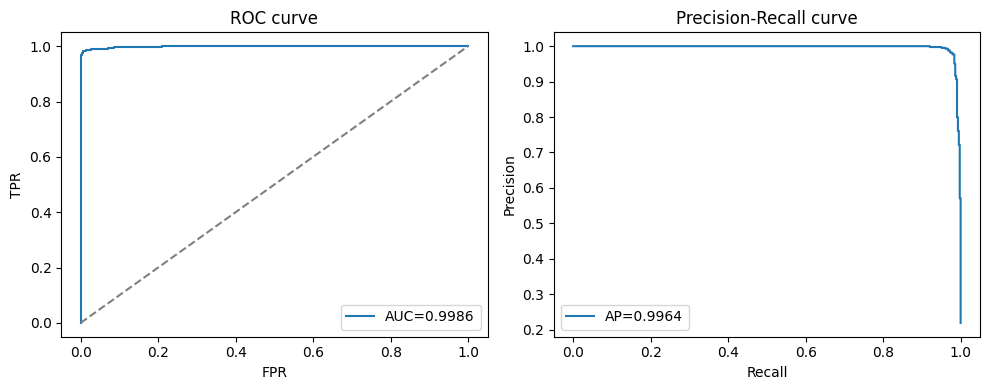


Loaded feature names (first 30): ['Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq rec contract addr', ' ERC20 min val rec', ' ERC20 max val rec', ' ERC20 avg val rec', ' ERC20 min val sent', ' ERC20 max val sent', ' ERC20 avg val sent', ' ERC20 uniq sent token name']

Top 20 feature importances (index, importance, name if available):
45 33190.750861462206  ERC20 most sent token type
38 30179.87333131209  ERC20 avg time between sent tnx
46 2038.3684740513563  ERC20_most_rec

In [65]:
# Quick comprehensive checks after training LightGBM (ROC/PR plots, test metrics, confusion matrix, feature importances, CV)
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, accuracy_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pickle
ARTIFACTS_DIR = globals().get("ARTIFACTS_DIR", "./artifacts")
SEED = globals().get("SEED", 42)

# Load test split
X_test = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
y_test = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))

# 1) Predict on test using best iteration
best_iter = getattr(bst, "best_iteration", None)
if best_iter is None:
    best_iter = None  # let predict choose full booster rounds
test_probs = bst.predict(X_test, num_iteration=best_iter)
test_pred  = (test_probs > 0.5).astype(int)

# 2) Metrics
test_auc = roc_auc_score(y_test, test_probs) if len(np.unique(y_test))>1 else float('nan')
test_ap  = average_precision_score(y_test, test_probs)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, test_pred, average='binary', zero_division=0)
acc = accuracy_score(y_test, test_pred)
print("TEST METRICS")
print(f"ROC-AUC: {test_auc:.6f}   PR-AUC: {test_ap:.6f}")
print(f"precision: {prec:.6f}, recall: {rec:.6f}, f1: {f1:.6f}, acc: {acc:.6f}\n")

# 3) Confusion matrix
cm = confusion_matrix(y_test, test_pred)
print("Confusion matrix (rows=true, cols=pred):\n", cm)

# 4) ROC + PR curves
fpr, tpr, _ = roc_curve(y_test, test_probs)
pp, rp, _  = precision_recall_curve(y_test, test_probs)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC={test_auc:.4f}")
plt.plot([0,1],[0,1],'--', color='grey')
plt.title("ROC curve")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rp, pp, label=f"AP={test_ap:.4f}")
plt.title("Precision-Recall curve")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.tight_layout()
plt.show()

# 5) Feature names + importances (map indices -> names using saved preproc artifact)
feat_names = None
pkl_path = os.path.join(ARTIFACTS_DIR, "preproc_train_encoders.pkl")
if os.path.exists(pkl_path):
    with open(pkl_path, "rb") as f:
        enc = pickle.load(f)
    # enc expected keys: numeric_cols, categorical_cols, feature_cols
    numeric_cols = enc.get("numeric_cols", [])
    categorical_cols = enc.get("categorical_cols", [])
    # Reconstruct final feature order used when building X_all in preprocessing:
    feat_names = numeric_cols + categorical_cols
    print("\nLoaded feature names (first 30):", feat_names[:30])
else:
    print("\nNo preproc_train_encoders.pkl found in artifacts; feature names unavailable.")

# 6) Print top feature importances by gain (if available)
try:
    importances = bst.feature_importance(importance_type='gain')
    idx_sort = np.argsort(importances)[::-1]
    print("\nTop 20 feature importances (index, importance, name if available):")
    for idx in idx_sort[:20]:
        name = feat_names[idx] if feat_names is not None and idx < len(feat_names) else "feat_"+str(idx)
        print(idx, importances[idx], name)
except Exception as e:
    print("Could not get feature importances from bst:", e)

# 7) Quick 5-fold stratified CV on training+val to check robustness (may take time)
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
X_cv = np.vstack([X_train, X_val])
y_cv = np.concatenate([y_train, y_val])

from sklearn.model_selection import StratifiedKFold
clf_wrap = None
try:
    # Use sklearn wrapper for cross_val_score
    clf_wrap = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.05, num_leaves=10,
                                  min_data_in_leaf=100, objective='binary', random_state=SEED, n_estimators=bst.num_trees())
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = cross_val_score(clf_wrap, X_cv, y_cv, cv=cv, scoring='roc_auc', n_jobs=-1)
    print(f"\n5-fold CV ROC-AUC (train+val): mean={scores.mean():.4f}, std={scores.std():.4f}")
except Exception as e:
    print("CV step skipped/failed:", e)

# 8) Save the trained booster to disk (optional but recommended)
save_path = os.path.join(ARTIFACTS_DIR, "lightgbm_booster.txt")
bst.save_model(save_path)
print("\nSaved booster to", save_path)


In [66]:
import numpy as np, os, pickle, pandas as pd
ART = "./artifacts"
X = np.load(os.path.join(ART, "X_test.npy"))  # or X_train for train-side check
pkl = os.path.join(ART, "preproc_train_encoders.pkl")
enc = pickle.load(open(pkl,'rb'))
feat_names = enc['numeric_cols'] + enc['categorical_cols']
n_rows = X.shape[0]
for i,name in enumerate(feat_names):
    try:
        uniq = np.unique(np.load(os.path.join(ART,"X_train.npy"))[:,i]).shape[0]
    except Exception:
        uniq = None
    if uniq is not None and uniq >= 0.9 * n_rows:
        print(f"Feature {i} '{name}' has {uniq} unique values (>=90% of rows) -- POSSIBLE ID/LEAK")
        
import numpy as np, os, pickle
ART = "./artifacts"
feat_names = pickle.load(open(os.path.join(ART,"preproc_train_encoders.pkl"),"rb"))['numeric_cols'] + pickle.load(open(os.path.join(ART,"preproc_train_encoders.pkl"),"rb"))['categorical_cols']
top_idxs = [45,37,20]   # example from your top importances — adjust if different
# reconstruct addresses+labels (train/test concatenation used for graph earlier)
y_test = np.load(os.path.join(ART,"y_test.npy"))
X_test = np.load(os.path.join(ART,"X_test.npy"))
for idx in top_idxs:
    col = X_test[:, idx]
    # for categorical-style columns, show top categories and their fraud rate
    vals, counts = np.unique(col, return_counts=True)
    topk = vals[np.argsort(counts)[-10:]][::-1]   # 10 most frequent encoded values
    print("\nFeature", idx, feat_names[idx], "top-10 encoded values and fraud rates (value -> count -> frac_pos):")
    for v in topk:
        mask = (col == v)
        frac = y_test[mask].mean() if mask.sum()>0 else None
        print(v, int(mask.sum()), frac)
        
import numpy as np, os
a_tr = np.load(os.path.join(ART,"addresses_train.npy"), allow_pickle=True)
a_te = np.load(os.path.join(ART,"addresses_test.npy"), allow_pickle=True)
print("Overlap train/test addresses:", len(set(a_tr) & set(a_te)))


Feature 0 'Avg min between sent tnx' has 3576 unique values (>=90% of rows) -- POSSIBLE ID/LEAK
Feature 1 'Avg min between received tnx' has 4241 unique values (>=90% of rows) -- POSSIBLE ID/LEAK
Feature 2 'Time Diff between first and last (Mins)' has 5437 unique values (>=90% of rows) -- POSSIBLE ID/LEAK
Feature 7 'min value received' has 3191 unique values (>=90% of rows) -- POSSIBLE ID/LEAK
Feature 8 'max value received ' has 4342 unique values (>=90% of rows) -- POSSIBLE ID/LEAK
Feature 9 'avg val received' has 4599 unique values (>=90% of rows) -- POSSIBLE ID/LEAK
Feature 10 'min val sent' has 3306 unique values (>=90% of rows) -- POSSIBLE ID/LEAK
Feature 11 'max val sent' has 4607 unique values (>=90% of rows) -- POSSIBLE ID/LEAK
Feature 12 'avg val sent' has 3995 unique values (>=90% of rows) -- POSSIBLE ID/LEAK
Feature 14 'total Ether sent' has 4001 unique values (>=90% of rows) -- POSSIBLE ID/LEAK
Feature 15 'total ether received' has 4565 unique values (>=90% of rows) -- POSS

In [67]:
import os, pickle, numpy as np
ART = "./artifacts"
enc = pickle.load(open(os.path.join(ART, "preproc_train_encoders.pkl"), "rb"))
categorical_cols = enc['categorical_cols']
# find index of the suspicious column (the name printed earlier)
susp_col_name = " ERC20 most sent token type"  # adjust if the exact string differs
try:
    col_pos = categorical_cols.index(susp_col_name)
except ValueError:
    # print candidate column names to pick correct one
    print("categorical_cols keys (first 60):", categorical_cols[:60])
    raise

# get encoder info
cat_enc = enc['cat_encoders'][susp_col_name]
mapping = cat_enc['mapping']   # value -> encoded_index
# invert mapping: encoded_index -> original_value
inv_map = {v:k for k,v in mapping.items()}

# print top few encodings sorted by encoded index and the actual token string
for enc_idx in sorted(inv_map.keys())[:60]:
    print(enc_idx, inv_map[enc_idx])
# Check what actual string corresponds to encoded index which was flagged as '1.0'
print("Encoded index 1 maps to:", inv_map.get(1))

import numpy as np, os
ART = "./artifacts"
# load arrays
X_train = np.load(os.path.join(ART, "X_train.npy"))
y_train = np.load(os.path.join(ART, "y_train.npy"))
X_test  = np.load(os.path.join(ART, "X_test.npy"))
y_test  = np.load(os.path.join(ART, "y_test.npy"))

# get categorical order
enc = pickle.load(open(os.path.join(ART, "preproc_train_encoders.pkl"), "rb"))
numeric_cols = enc['numeric_cols']; categorical_cols = enc['categorical_cols']
scol = " ERC20 most sent token type"   # adjust if needed
col_idx_global = len(numeric_cols) + categorical_cols.index(scol)  # global column index in X arrays

# examine top token codes in train/test
def show_top_codes(X, y, col_idx, topk=20):
    vals, counts = np.unique(X[:, col_idx], return_counts=True)
    order = np.argsort(counts)[::-1][:topk]
    for o in order:
        v = vals[o]; c = counts[o]
        mask = (X[:, col_idx] == v)
        frac_pos = y[mask].mean() if mask.sum()>0 else None
        print(f"code={v} count={c} frac_pos={frac_pos:.4f}")
print("TRAIN top codes:")
show_top_codes(X_train, y_train, col_idx_global, topk=30)
print("\nTEST top codes:")
show_top_codes(X_test, y_test, col_idx_global, topk=30)

from sklearn.metrics import roc_auc_score
import numpy as np, os
ART = "./artifacts"

# load model (bst) and X_test,y_test
import lightgbm as lgb
bst = lgb.Booster(model_file=os.path.join(ART,"lightgbm_booster.txt"))
X_test = np.load(os.path.join(ART, "X_test.npy")).copy()
y_test = np.load(os.path.join(ART, "y_test.npy"))

# compute baseline
base_probs = bst.predict(X_test)
base_auc = roc_auc_score(y_test, base_probs)
print("Baseline AUC:", base_auc)

# shuffle the suspicious column(s)
cols_to_test = [col_idx_global]   # list of global indices: e.g. [col_idx_global, other_idx]
X_shuf = X_test.copy()
np.random.seed(42)
X_shuf[:, cols_to_test] = np.random.permutation(X_shuf[:, cols_to_test])
shuf_probs = bst.predict(X_shuf)
print("AUC after shuffling top token col:", roc_auc_score(y_test, shuf_probs))

import os, numpy as np, lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score
ART = "./artifacts"
enc = pickle.load(open(os.path.join(ART,"preproc_train_encoders.pkl"),"rb"))
numeric_cols = enc['numeric_cols']; categorical_cols = enc['categorical_cols']
# define token-like columns to drop by exact name or matching substring
drop_substrings = ["token", "ERC20 most", "most sent", "most rec", "uniq sent token name", "token type"]
drop_cols = [c for c in categorical_cols if any(s.lower() in c.lower() for s in drop_substrings)]
print("Dropping columns:", drop_cols)

# compute indices to remove from X arrays
drop_indices = [ len(numeric_cols) + categorical_cols.index(c) for c in drop_cols ]

# load splits
X_train = np.load(os.path.join(ART, "X_train.npy"))
X_val   = np.load(os.path.join(ART, "X_val.npy"))
X_test  = np.load(os.path.join(ART, "X_test.npy"))
y_train = np.load(os.path.join(ART, "y_train.npy"))
y_val   = np.load(os.path.join(ART, "y_val.npy"))
y_test  = np.load(os.path.join(ART, "y_test.npy"))

# delete columns
X_train_red = np.delete(X_train, drop_indices, axis=1)
X_val_red   = np.delete(X_val, drop_indices, axis=1)
X_test_red  = np.delete(X_test, drop_indices, axis=1)
print("Shapes after drop:", X_train_red.shape, X_val_red.shape, X_test_red.shape)

# retrain (use same params/callbacks as before)
params = {'boosting_type':'gbdt','learning_rate':0.05,'num_leaves':10,'min_data_in_leaf':100,'objective':'binary','metric':'auc','seed':42,'verbose':-1}
dtrain = lgb.Dataset(X_train_red, label=y_train); dval = lgb.Dataset(X_val_red, label=y_val, reference=dtrain)
bst2 = lgb.train(params, dtrain, num_boost_round=1000, valid_sets=[dval], callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
probs2 = bst2.predict(X_test_red, num_iteration=bst2.best_iteration or None)
print("AUC without token-name features:", roc_auc_score(y_test, probs2))
print("PR-AUC without token-name features:", average_precision_score(y_test, probs2))


0 
1  
2 ''
3 0
4 0xcert Protocol Token
5 1World
6 <<NA>>
7 AION
8 AVT
9 AdBank
10 AdEx
11 Aditus
12 Adshares
13 Aeron
14 Aeternity
15 AirSwap
16 AirToken
17 AnyCoinVer10
18 AppCoins
19 Aragon
20 ArcBlock
21 Authorship
22 BAI
23 BANCA
24 BANKEX
25 BAT
26 BCDN
27 BCG.to
28 BNB
29 Bancor
30 Banker Token
31 BitDice
32 Blackmoon Crypto Token
33 BlockchainPoland
34 Blocktix
35 Bounty0x
36 Bytom
37 CCRB
38 CRYPTOPUNKS
39 Cai Token
40 Cashaa
41 Celsius
42 Centra
43 CharterCoin
44 Cindicator
45 Civic
46 Cofoundit
47 CoinBene Coin
48 CoinBoin
49 CoinDash
50 Crypto.com
51 Crypto20
52 Cryptonex
53 DADI
54 DAPSTOKEN
55 DATAcoin
56 DCORP
57 DGD
58 DICE
59 DNA
Encoded index 1 maps to:  
TRAIN top codes:
code=3.0 count=3006 frac_pos=0.0000
code=6.0 count=1812 frac_pos=0.3074
code=1.0 count=819 frac_pos=1.0000
code=145.0 count=100 frac_pos=0.0400
code=74.0 count=93 frac_pos=0.0215
code=91.0 count=91 frac_pos=0.0440
code=228.0 count=85 frac_pos=0.2941
code=182.0 count=40 frac_pos=0.0000
code=25.0 coun

In [68]:
import pickle, os
ART = "./artifacts"
pkl = os.path.join(ART, "preproc_train_encoders.pkl")
enc = pickle.load(open(pkl, "rb"))
categorical_cols = enc.get("categorical_cols", [])
print("Number of categorical columns:", len(categorical_cols))
for i, name in enumerate(categorical_cols):
    print(i, repr(name))
# If there are many columns, you can show only first N:
# for i, name in enumerate(categorical_cols[:80]): print(i, repr(name))


Number of categorical columns: 16
0 'Number of Created Contracts'
1 'min value sent to contract'
2 'max val sent to contract'
3 'avg value sent to contract'
4 'total ether sent contracts'
5 ' ERC20 total Ether sent contract'
6 ' ERC20 uniq sent addr.1'
7 ' ERC20 avg time between sent tnx'
8 ' ERC20 avg time between rec tnx'
9 ' ERC20 avg time between rec 2 tnx'
10 ' ERC20 avg time between contract tnx'
11 ' ERC20 min val sent contract'
12 ' ERC20 max val sent contract'
13 ' ERC20 avg val sent contract'
14 ' ERC20 most sent token type'
15 ' ERC20_most_rec_token_type'


In [69]:
# run once on the raw token-name column in your df (before encoding)
tok_col = " ERC20 most sent token type"   # change if your name differs
# If you saved the original mapping in preproc_train_encoders, you still should clean the raw df first
df[tok_col] = df[tok_col].astype(str).str.strip().replace({'': None, '0': None, '<<NA>>': None})
# Re-run your encoding pipeline (fit on train only) after this cleaning.

# Fast ablation: shuffle selected columns in X_test and measure AUC drop
import numpy as np, os
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

ART = "./artifacts"
bst = lgb.Booster(model_file=os.path.join(ART,"lightgbm_booster.txt"))
X_test = np.load(os.path.join(ART,"X_test.npy")).copy()
y_test = np.load(os.path.join(ART,"y_test.npy"))

def ablation_auc(cols):
    Xs = X_test.copy()
    for c in cols:
        rng = np.random.default_rng(42)
        Xs[:, c] = rng.permutation(Xs[:, c])
    probs = bst.predict(Xs, num_iteration=bst.best_iteration or None)
    return roc_auc_score(y_test, probs)

base_auc = roc_auc_score(y_test, bst.predict(X_test, num_iteration=bst.best_iteration or None))
print("Base AUC:", base_auc)

# try the top features (replace indices with your top ones)
top_indices = [45, 37, 20, 2]   # token-name, uniq-sent-addr, uniq-sent-addr count, time-diff
for i in top_indices:
    auc_i = ablation_auc([i])
    print(f"Shuffled feature {i} -> AUC: {auc_i:.6f} (drop {base_auc-auc_i:.6f})")

# Try shuffling top-3 together
auc_top3 = ablation_auc(top_indices[:3])
print("Shuffling top-3 together -> AUC:", auc_top3, "drop:", base_auc-auc_top3)

# compute AUC drop for top N features to rank importance (manual permutation)
import numpy as np, os
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
ART = "./artifacts"
bst = lgb.Booster(model_file=os.path.join(ART,"lightgbm_booster.txt"))
X_test = np.load(os.path.join(ART,"X_test.npy")).copy()
y_test = np.load(os.path.join(ART,"y_test.npy"))

def perm_importance_topk(k=20):
    base = roc_auc_score(y_test, bst.predict(X_test, num_iteration=bst.best_iteration or None))
    drops = []
    for c in range(X_test.shape[1]):
        Xs = X_test.copy()
        rng = np.random.default_rng(42)
        Xs[:, c] = rng.permutation(Xs[:, c])
        auc = roc_auc_score(y_test, bst.predict(Xs, num_iteration=bst.best_iteration or None))
        drops.append(base - auc)
    drops = np.array(drops)
    idxs = np.argsort(drops)[::-1][:k]
    return list(zip(idxs, drops[idxs]))

topk = perm_importance_topk(20)
print("Top features by permutation AUC drop (index, drop):")
print(topk)


Base AUC: 0.9986098056456748
Shuffled feature 45 -> AUC: 0.909715 (drop 0.088895)
Shuffled feature 37 -> AUC: 0.998610 (drop 0.000000)
Shuffled feature 20 -> AUC: 0.998536 (drop 0.000074)
Shuffled feature 2 -> AUC: 0.996616 (drop 0.001994)
Shuffling top-3 together -> AUC: 0.9099375397956397 drop: 0.08867226585003507
Top features by permutation AUC drop (index, drop):
[(np.int64(45), np.float64(0.0888951214335526)), (np.int64(38), np.float64(0.03484733634516857)), (np.int64(46), np.float64(0.0055092325884600335)), (np.int64(5), np.float64(0.003994724235165781)), (np.int64(2), np.float64(0.0019935720566387483)), (np.int64(9), np.float64(0.0009384190897789857)), (np.int64(21), np.float64(0.0007231436281496251)), (np.int64(7), np.float64(0.0006139898729572435)), (np.int64(1), np.float64(0.0004775476789667943)), (np.int64(17), np.float64(0.0002425639004276503)), (np.int64(24), np.float64(0.00013644219399056023)), (np.int64(11), np.float64(0.00013644219399056023)), (np.int64(12), np.float64(

In [70]:
# Robust re-train after collapsing rare categories (train-only freq threshold)
import os, pickle, numpy as np, pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, accuracy_score

ART = "./artifacts"
SEED = globals().get("SEED", 42)
RARE_THRESHOLD = 50   # <--- tune: treat values occurring < 50 in train as 'OTHER'

# Load preproc artifact to get numeric/categorical col lists
enc = pickle.load(open(os.path.join(ART, "preproc_train_encoders.pkl"), "rb"))
numeric_cols = enc.get("numeric_cols", [])
categorical_cols = enc.get("categorical_cols", [])

# Determine global column indices in X arrays: numeric first, then categorical
def global_index(cat_idx):
    return len(numeric_cols) + cat_idx

# Load X/y splits
X_train = np.load(os.path.join(ART, "X_train.npy"))
X_val   = np.load(os.path.join(ART, "X_val.npy"))
X_test  = np.load(os.path.join(ART, "X_test.npy"))
y_train = np.load(os.path.join(ART, "y_train.npy"))
y_val   = np.load(os.path.join(ART, "y_val.npy"))
y_test  = np.load(os.path.join(ART, "y_test.npy"))

# Convert categorical columns back to integer-coded arrays (they already are encoded ints),
# but we need original mappings to map codes -> token strings only if you saved original raw df.
# Simpler approach: work on encoded integer codes: find freq of each code in train and mark rare ones.

X_tr = X_train.copy(); X_va = X_val.copy(); X_te = X_test.copy()

cols_to_sanitize = []
for ci, cname in enumerate(categorical_cols):
    gidx = global_index(ci)
    vals, counts = np.unique(X_tr[:, gidx], return_counts=True)
    # identify rare encoded values (in train)
    rare_vals = set(vals[counts < RARE_THRESHOLD])
    if len(rare_vals) > 0:
        cols_to_sanitize.append((gidx, cname, len(rare_vals)))
        # map these rare codes to a new code index: choose a new integer not used in train encodings
        used_codes = set(vals)
        new_code = int(max(used_codes) + 1)  # safe new code integer
        # apply mapping: in train/val/test replace rare_vals -> new_code
        mask_tr = np.isin(X_tr[:, gidx], list(rare_vals))
        X_tr[mask_tr, gidx] = new_code
        mask_va = np.isin(X_va[:, gidx], list(rare_vals))
        X_va[mask_va, gidx] = new_code
        mask_te = np.isin(X_te[:, gidx], list(rare_vals))
        X_te[mask_te, gidx] = new_code

print("Sanitized columns (gidx, name, #rare_codes):\n", cols_to_sanitize[:20])

# Now X_tr/X_va/X_te have rare values collapsed into a single new code per column.
# Retrain LightGBM on X_tr with X_va as validation
params = {
    'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 10,
    'min_data_in_leaf': 100, 'objective': 'binary', 'metric': 'auc',
    'seed': SEED, 'verbose': -1
}
dtrain = lgb.Dataset(X_tr, label=y_train)
dval   = lgb.Dataset(X_va, label=y_val, reference=dtrain)
bst2 = lgb.train(params, dtrain, num_boost_round=1000, valid_sets=[dtrain, dval],
                 valid_names=['train','valid'], callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)])

# Predict on test
best_iter = getattr(bst2, "best_iteration", None) or None
probs = bst2.predict(X_te, num_iteration=best_iter)
preds = (probs > 0.5).astype(int)

# Metrics
auc = roc_auc_score(y_test, probs)
ap  = average_precision_score(y_test, probs)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary', zero_division=0)
acc = accuracy_score(y_test, preds)

print("After collapsing rare tokens (threshold={}):".format(RARE_THRESHOLD))
print(f"Test ROC-AUC: {auc:.6f}, PR-AUC: {ap:.6f}")
print(f"precision: {prec:.6f}, recall: {rec:.6f}, f1: {f1:.6f}, acc: {acc:.6f}")

# Optional: compare to baseline model AUC you previously had
base_auc = 0.9993814620539099
print("Base AUC was:", base_auc, "New AUC:", auc, "Drop:", base_auc - auc)


Sanitized columns (gidx, name, #rare_codes):
 [(31, 'Number of Created Contracts', 13), (32, 'min value sent to contract', 2), (33, 'max val sent to contract', 2), (34, 'avg value sent to contract', 2), (35, 'total ether sent contracts', 2), (36, ' ERC20 total Ether sent contract', 16), (37, ' ERC20 uniq sent addr.1', 1), (45, ' ERC20 most sent token type', 230), (46, ' ERC20_most_rec_token_type', 349)]
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999914	valid's auc: 0.999374
[200]	train's auc: 1	valid's auc: 0.999673
[300]	train's auc: 1	valid's auc: 0.99975
[400]	train's auc: 1	valid's auc: 0.999794
Early stopping, best iteration is:
[425]	train's auc: 1	valid's auc: 0.999814
After collapsing rare tokens (threshold=50):
Test ROC-AUC: 0.999219, PR-AUC: 0.998079
precision: 1.000000, recall: 0.972093, f1: 0.985849, acc: 0.993890
Base AUC was: 0.9993814620539099 New AUC: 0.9992192474454988 Drop: 0.00016221460841103763


In [71]:
# === Robust KNN graph builder that ensures X/y/addresses alignment ===
import os, numpy as np, torch
from sklearn.neighbors import NearestNeighbors

ARTIFACTS_DIR = globals().get("ARTIFACTS_DIR", "./artifacts")
K = 10
SEED = globals().get("SEED", 42)
print("Building kNN graph with k=", K)

# helper loader
def safe_load(path, allow_pickle=False):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    return np.load(path, allow_pickle=allow_pickle)

# 1) Load splits (they should exist if previous cell saved them)
X_train = safe_load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
X_val   = safe_load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
X_test  = safe_load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
# labels
y_train = safe_load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
y_val   = safe_load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
y_test  = safe_load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))
# addresses saved as object arrays -> allow_pickle True
a_tr = safe_load(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), allow_pickle=True)
a_va = safe_load(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), allow_pickle=True)
a_te = safe_load(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), allow_pickle=True)

# 2) Concatenate to full arrays (train->val->test ordering)
X = np.vstack([X_train, X_val, X_test])
addresses = np.concatenate([a_tr, a_va, a_te])

# if y parts align to address parts, use them; otherwise attempt to rebuild y from address->label mapping
use_y_concat = True
try:
    y = np.concatenate([y_train, y_val, y_test])
except Exception as e:
    print("Warning: couldn't concat y parts directly:", e)
    use_y_concat = False

print("Post-concat shapes: X:", X.shape, "addresses:", addresses.shape, "y_concat:", (y.shape if use_y_concat else None))

# 3) If lengths match, we're OK; otherwise attempt repair using addresses -> label mapping
if use_y_concat and X.shape[0] == y.shape[0]:
    print("X and y lengths match — good (", X.shape[0], "nodes )")
else:
    # Attempt repair: build mapping from (addresses from splitted arrays) -> labels if possible
    print("Attempting to align labels using addresses ...")
    addr_label_map = {}
    # If we had y parts that match their addresses parts, build mapping
    try:
        # map each split's addresses to its y (if lengths match for that split)
        if len(a_tr) == len(y_train):
            addr_label_map.update({ addr: int(lbl) for addr,lbl in zip(a_tr, y_train) })
        if len(a_va) == len(y_val):
            addr_label_map.update({ addr: int(lbl) for addr,lbl in zip(a_va, y_val) })
        if len(a_te) == len(y_test):
            addr_label_map.update({ addr: int(lbl) for addr,lbl in zip(a_te, y_test) })
        print(f"Built addr->label map for {len(addr_label_map)} addresses from split label arrays.")
    except Exception as e:
        print("Could not build addr->label map from split y arrays:", e)

    # If still insufficient, try to use in-memory df or df_dedup if present
    if len(addr_label_map) < X.shape[0]:
        if 'df_dedup' in globals():
            df_map = df_dedup
            print("Using df_dedup in memory to map addresses -> FLAG for missing labels.")
        elif 'df' in globals():
            df_map = df
            print("Using original df in memory to map addresses -> FLAG for missing labels.")
        else:
            df_map = None

        if df_map is not None:
            # create address -> label mapping from dataframe (ensure Address & FLAG exist)
            if 'Address' in df_map.columns and 'FLAG' in df_map.columns:
                mem_map = dict(zip(df_map['Address'].astype(str).values, df_map['FLAG'].astype(int).values))
                # update missing addresses only
                missing_count_before = sum(1 for addr in addresses if addr not in addr_label_map)
                added = 0
                for addr in addresses:
                    if addr not in addr_label_map and addr in mem_map:
                        addr_label_map[addr] = int(mem_map[addr])
                        added += 1
                print(f"Added {added} labels from in-memory dataframe (missing before: {missing_count_before}).")
            else:
                print("In-memory df does not have Address/FLAG columns — cannot map via df.")
        else:
            print("No in-memory dataframe available to map addresses -> labels.")

    # Now attempt to build y by mapping addresses -> label
    y_rebuilt = []
    missing_labels = []
    for addr in addresses:
        if addr in addr_label_map:
            y_rebuilt.append(addr_label_map[addr])
        else:
            missing_labels.append(addr)
            y_rebuilt.append(-1)  # placeholder

    y_rebuilt = np.array(y_rebuilt, dtype=int)
    n_missing = np.sum(y_rebuilt == -1)
    if n_missing > 0:
        # too many missing labels -> bail out and ask for manual fix
        raise ValueError(
            f"Unable to align labels automatically: {n_missing} addresses have no label mapping.\n"
            "Check your saved splits in ARTIFACTS_DIR and ensure addresses and labels were saved consistently.\n"
            "If you want an automatic but risky fix, we can drop rows with missing labels or fill them, but that may change results."
        )
    # replace y with rebuilt
    y = y_rebuilt
    print("Successfully rebuilt y from addresses mapping. Node count:", X.shape[0])

# final safety assert
assert X.shape[0] == y.shape[0], f"Still inconsistent after repair: X {X.shape[0]} vs y {y.shape[0]}"

# 4) Build kNN graph (cosine) on X
from sklearn.neighbors import NearestNeighbors
N = X.shape[0]
n_neighbors = min(K+1, N)
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', n_jobs=-1).fit(X)
dists, neigh = knn.kneighbors(X, return_distance=True)

rows = []
cols = []
for i in range(N):
    # skip self (first neighbor)
    neighs = neigh[i, 1: min(K+1, neigh.shape[1])]
    for j in neighs:
        rows.append(i)
        cols.append(int(j))

# make undirected edges (add reverse)
edge_index = torch.tensor([rows + cols, cols + rows], dtype=torch.long)

# Convert features & labels to torch tensors
x_nodes = torch.tensor(X, dtype=torch.float)
y_nodes = torch.tensor(y, dtype=torch.long)

# Save artifacts
torch.save({'edge_index': edge_index, 'x': x_nodes, 'y': y_nodes, 'addresses': addresses},
           os.path.join(ARTIFACTS_DIR, 'graph_artifacts.pt'))
print('Saved graph artifacts. Nodes:', N, 'Edges:', edge_index.shape[1])


Building kNN graph with k= 10
Post-concat shapes: X: (9816, 47) addresses: (9816,) y_concat: (9816,)
X and y lengths match — good ( 9816 nodes )
Saved graph artifacts. Nodes: 9816 Edges: 196320


In [72]:
# === Revised GNN (GraphSAGE) training & evaluation ===
import os, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
from torch_geometric.nn import SAGEConv
ARTIFACTS_DIR = globals().get("ARTIFACTS_DIR", "./artifacts")
SEED = globals().get("SEED", 42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Load graph artifacts (must contain 'edge_index','x','y','addresses')
art_path = os.path.join(ARTIFACTS_DIR, 'graph_artifacts.pt')
art = torch.load(art_path)
edge_index = art['edge_index'].to(device)
x_nodes = art['x'].to(device)
y_nodes = art['y'].to(device)
graph_addresses = np.asarray(art.get('addresses', []), dtype=object)

# --- SANITY: load the saved addresses splits to derive canonical indices for train/val/test ---
a_tr = np.load(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), allow_pickle=True)
a_va = np.load(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), allow_pickle=True)
a_te = np.load(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), allow_pickle=True)

# Build address -> node_index mapping using the addresses stored with the graph (these must match exactly)
if len(graph_addresses) == 0:
    raise RuntimeError("graph_artifacts.pt does not contain 'addresses'. Recreate graph_artifacts with addresses preserved.")
addr_to_idx = {addr: i for i, addr in enumerate(graph_addresses)}

# Map canonical address splits to node indices (this guarantees train/val/test match earlier preprocessing)
def map_addresses_to_indices(addr_list):
    idxs = []
    missing = []
    for a in addr_list:
        if a in addr_to_idx:
            idxs.append(addr_to_idx[a])
        else:
            missing.append(a)
    return np.array(idxs, dtype=np.int64), missing

train_idx, missing_tr = map_addresses_to_indices(a_tr)
val_idx, missing_va = map_addresses_to_indices(a_va)
test_idx, missing_te = map_addresses_to_indices(a_te)

# Report any missing addresses in the graph (these would cause mismatches)
if len(missing_tr) + len(missing_va) + len(missing_te) > 0:
    print("WARNING: Some addresses saved in addresses_*.npy were not found in graph_artifacts addresses.")
    print(" missing counts -> train:", len(missing_tr), "val:", len(missing_va), "test:", len(missing_te))
    # Option: fall back to contiguous split if you intentionally have unlabeled/isolated nodes
    # For safety we raise here to force you to check; comment out raise if intentional.
    raise ValueError("Address mismatch between saved splits and graph nodes. Recreate graph_artifacts or adjust mapping.")

print(f"Mapped canonical splits -> train:{len(train_idx)}, val:{len(val_idx)}, test:{len(test_idx)}")
# Final safety: check x/y alignment counts
n_x = x_nodes.shape[0]; n_y = y_nodes.shape[0]
if n_x != n_y:
    raise ValueError(f"Mismatch: x_nodes {n_x} vs y_nodes {n_y}. Recreate graph_artifacts with consistent x and y.")

# --- Define GraphSAGE node classifier ---
class NodeGNN(nn.Module):
    def __init__(self, in_ch, hidden=128, num_layers=2):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_ch, hidden))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden, hidden))
        self.head = nn.Linear(hidden, 1)

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        return self.head(x).squeeze(-1)

model = NodeGNN(in_ch=x_nodes.shape[1], hidden=128, num_layers=2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Balanced BCE loss
pos_weight = (y_nodes==0).sum().float() / (y_nodes==1).sum().float() if (y_nodes==1).sum()>0 else torch.tensor(1.0)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

# Training loop
EPOCHS = 100
for epoch in range(1, EPOCHS+1):
    model.train()
    opt.zero_grad()
    logits = model(x_nodes, edge_index)               # logits for all nodes
    loss = loss_fn(logits[train_idx], y_nodes[train_idx].float())
    loss.backward()
    opt.step()

    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            logits_eval = model(x_nodes, edge_index)
            val_probs = torch.sigmoid(logits_eval[val_idx]).cpu().numpy()
            val_preds = (val_probs > 0.5).astype(int)
            val_true = y_nodes[val_idx].cpu().numpy().astype(int)
            try:
                auc_val = roc_auc_score(val_true, val_probs)
            except Exception:
                auc_val = float('nan')
            prec, rec, f1, _ = precision_recall_fscore_support(val_true, val_preds, average='binary', zero_division=0)
        print(f'Epoch {epoch} loss={loss.item():.4f} val_auc={auc_val:.4f} prec={prec:.4f} rec={rec:.4f} f1={f1:.4f}')

# Final evaluation on canonical test indices
model.eval()
with torch.no_grad():
    logits_final = model(x_nodes, edge_index)
    probs_all = torch.sigmoid(logits_final).cpu().numpy().squeeze()
    test_probs = probs_all[test_idx]
    test_preds = (test_probs > 0.5).astype(int)
    test_true = y_nodes[test_idx].cpu().numpy().astype(int)

# Save artifacts with canonical names expected by comparison cell
np.save(os.path.join(ARTIFACTS_DIR, "gnn_test_probs.npy"), test_probs)
np.save(os.path.join(ARTIFACTS_DIR, "gnn_test_preds.npy"), test_preds)
np.save(os.path.join(ARTIFACTS_DIR, "gnn_test_true.npy"), test_true)
print("Saved GNN artifacts:", "gnn_test_probs.npy, gnn_test_preds.npy, gnn_test_true.npy")

# Print final test metrics
test_auc = roc_auc_score(test_true, test_probs) if len(np.unique(test_true)) > 1 else float('nan')
prec, rec, f1, _ = precision_recall_fscore_support(test_true, test_preds, average='binary', zero_division=0)
acc = accuracy_score(test_true, test_preds)
print('GNN TEST metrics -> auc: {:.6f}, prec: {:.6f}, rec: {:.6f}, f1: {:.6f}, acc: {:.6f}'.format(test_auc, prec, rec, f1, acc))


Device: cuda
Mapped canonical splits -> train:6674, val:1178, test:1964
Epoch 5 loss=1.1830 val_auc=0.6935 prec=0.2692 rec=1.0000 f1=0.4241


C:\Users\manis\AppData\Local\Temp\ipykernel_20216\2925182345.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path)


Epoch 10 loss=1.1250 val_auc=0.6425 prec=0.9606 rec=0.4453 f1=0.6085
Epoch 15 loss=0.9743 val_auc=0.8317 prec=0.4823 rec=0.9453 f1=0.6387
Epoch 20 loss=0.8661 val_auc=0.7003 prec=0.9840 rec=0.4489 f1=0.6165
Epoch 25 loss=0.7601 val_auc=0.8797 prec=0.6005 rec=0.9161 f1=0.7254
Epoch 30 loss=0.7278 val_auc=0.8800 prec=0.5760 rec=0.9270 f1=0.7105
Epoch 35 loss=0.6715 val_auc=0.9323 prec=0.9544 rec=0.9161 f1=0.9348
Epoch 40 loss=0.6229 val_auc=0.9506 prec=0.8547 rec=0.9234 f1=0.8877
Epoch 45 loss=0.5634 val_auc=0.9349 prec=0.6487 rec=0.9234 f1=0.7620
Epoch 50 loss=0.4986 val_auc=0.9682 prec=0.8355 rec=0.9270 f1=0.8789
Epoch 55 loss=0.4351 val_auc=0.9585 prec=0.8586 rec=0.9307 f1=0.8932
Epoch 60 loss=0.3782 val_auc=0.9716 prec=0.9239 rec=0.9307 f1=0.9273
Epoch 65 loss=0.3251 val_auc=0.9747 prec=0.9304 rec=0.9270 f1=0.9287
Epoch 70 loss=0.2790 val_auc=0.9841 prec=0.9307 rec=0.9307 f1=0.9307
Epoch 75 loss=0.2410 val_auc=0.9838 prec=0.9307 rec=0.9307 f1=0.9307
Epoch 80 loss=0.2095 val_auc=0.987

In [73]:
# === Revised TabTransformer (uses canonical splits) ===
import os, numpy as np, torch, torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
ARTIFACTS_DIR = globals().get("ARTIFACTS_DIR", "./artifacts")
SEED = globals().get("SEED", 42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Load canonical splits saved during preprocessing
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))

# Stack them to create the canonical full matrix (train -> val -> test)
X_all = np.vstack([X_train, X_val, X_test])
y_all = np.concatenate([y_train, y_val, y_test])

# Build canonical indices that match how X_all was constructed
n_train = X_train.shape[0]
n_val   = X_val.shape[0]
n_test  = X_test.shape[0]
train_idx = np.arange(0, n_train)
val_idx   = np.arange(n_train, n_train + n_val)
test_idx  = np.arange(n_train + n_val, n_train + n_val + n_test)
print("Using canonical indices sizes -> train,val,test:", len(train_idx), len(val_idx), len(test_idx))

# Convert to tensors and move to device
X_t = torch.tensor(X_all, dtype=torch.float, device=device)
y_t = torch.tensor(y_all, dtype=torch.float, device=device)

# Compact TabTransformer-like model (projects row -> d_model and transformer encoder)
class TabTransformer(nn.Module):
    def __init__(self, num_cont, d_model=64, n_heads=4, n_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(num_cont, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.head = nn.Sequential(nn.Linear(d_model, 128), nn.ReLU(), nn.Dropout(dropout), nn.Linear(128,1))

    def forward(self, x_cont):
        token = self.input_proj(x_cont).unsqueeze(1)   # (B,1,d_model)
        token = self.transformer(token)                # (B,1,d_model)
        token = token.squeeze(1)                       # (B,d_model)
        logits = self.head(token).squeeze(-1)          # (B,)
        return logits

model_tab = TabTransformer(num_cont=X_all.shape[1], d_model=64, n_heads=4, n_layers=2).to(device)
opt = torch.optim.Adam(model_tab.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()

# minibatch generator
def batch_iter(idx_array, batch=256):
    n = len(idx_array)
    perm = np.random.permutation(idx_array)
    for i in range(0, n, batch):
        yield perm[i:i+batch]

EPOCHS = 50
BATCH = 256

for epoch in range(1, EPOCHS+1):
    model_tab.train()
    losses = []
    for b in batch_iter(train_idx, batch=BATCH):
        xb = X_t[b]
        yb = y_t[b]
        opt.zero_grad()
        logits = model_tab(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    if epoch % 5 == 0:
        model_tab.eval()
        with torch.no_grad():
            logits = torch.sigmoid(model_tab(X_t[val_idx])).cpu().numpy()
            preds = (logits > 0.5).astype(int)
            ytrue = y_all[val_idx].astype(int)
            auc_ = roc_auc_score(ytrue, logits) if len(np.unique(ytrue))>1 else float('nan')
            prec, rec, f1, _ = precision_recall_fscore_support(ytrue, preds, average='binary', zero_division=0)
        print(f'Epoch {epoch} loss={np.mean(losses):.4f} val_auc={auc_:.4f} prec={prec:.4f} rec={rec:.4f} f1={f1:.4f}')

# Evaluate on canonical test indices and save artifacts with canonical names
model_tab.eval()
with torch.no_grad():
    probs = torch.sigmoid(model_tab(X_t[test_idx])).cpu().numpy().squeeze()
    preds = (probs > 0.5).astype(int)
    ytrue = y_all[test_idx].astype(int)

np.save(os.path.join(ARTIFACTS_DIR, "tab_test_probs.npy"), probs)
np.save(os.path.join(ARTIFACTS_DIR, "tab_test_preds.npy"), preds)
np.save(os.path.join(ARTIFACTS_DIR, "tab_test_true.npy"), ytrue)
print("Saved TabTransformer artifacts:", "tab_test_probs.npy, tab_test_preds.npy, tab_test_true.npy")

# Print final test metrics
auc_ = roc_auc_score(ytrue, probs) if len(np.unique(ytrue))>1 else float('nan')
prec, rec, f1, _ = precision_recall_fscore_support(ytrue, preds, average='binary', zero_division=0)
acc = accuracy_score(ytrue, preds)
print('TabTransformer TEST metrics -> auc: {:.6f}, prec: {:.6f}, rec: {:.6f}, f1: {:.6f}, acc: {:.6f}'.format(auc_, prec, rec, f1, acc))


Device: cuda
Using canonical indices sizes -> train,val,test: 6674 1178 1964
Epoch 5 loss=0.1005 val_auc=0.9893 prec=1.0000 rec=0.8978 f1=0.9462
Epoch 10 loss=0.0591 val_auc=0.9932 prec=0.9960 rec=0.9124 f1=0.9524
Epoch 15 loss=0.0609 val_auc=0.9945 prec=0.9960 rec=0.9161 f1=0.9544
Epoch 20 loss=0.0541 val_auc=0.9948 prec=0.9960 rec=0.9161 f1=0.9544
Epoch 25 loss=0.0577 val_auc=0.9951 prec=0.9960 rec=0.9161 f1=0.9544
Epoch 30 loss=0.0496 val_auc=0.9950 prec=0.9960 rec=0.9161 f1=0.9544
Epoch 35 loss=0.0480 val_auc=0.9953 prec=0.9960 rec=0.9161 f1=0.9544
Epoch 40 loss=0.0548 val_auc=0.9953 prec=0.9960 rec=0.9161 f1=0.9544
Epoch 45 loss=0.0525 val_auc=0.9958 prec=0.9960 rec=0.9197 f1=0.9564
Epoch 50 loss=0.0513 val_auc=0.9957 prec=0.9960 rec=0.9197 f1=0.9564
Saved TabTransformer artifacts: tab_test_probs.npy, tab_test_preds.npy, tab_test_true.npy
TabTransformer TEST metrics -> auc: 0.994880, prec: 0.997442, rec: 0.906977, f1: 0.950061, acc: 0.979124


In [74]:
# 8) Compare & plots (basic)

try:
    import matplotlib.pyplot as plt
    from sklearn.metrics import precision_recall_curve

    # Ensure GNN model is in eval mode and compute GNN probabilities for the test node indices.
    # Note: `model` here is the GNN (NodeGNN) defined earlier; `x_nodes` and `edge_index` are full-graph tensors.
    model.eval()
    with torch.no_grad():
        # forward pass -> raw logits for all nodes, then sigmoid to get probabilities
        # finally index by test_idx to keep only the test-node probabilities
        gnn_probs = torch.sigmoid(model(x_nodes, edge_index)).cpu().numpy()[test_idx]

    # Compute precision-recall curve points for GNN using the true test labels from the combined y array.
    pr_g, rc_g, _ = precision_recall_curve(y[test_idx], gnn_probs)

    # Compute precision-recall curve points for the TabTransformer.
    # IMPORTANT: this uses `logits` and `ytrue` variables created previously in the TabTransformer cell.
    # `logits` here should contain the TabTransformer probabilities from that cell (after sigmoid).
    # If `logits` was overwritten, this call may be incorrect — ensure the TabTransformer evaluation
    # block ran before this cell and that `logits` contains the TabTransformer outputs.
    pr_t, rc_t, _ = precision_recall_curve(ytrue, logits)

    # Plot PR curves for both models for visual comparison
    plt.figure(figsize=(8,5))
    plt.plot(rc_g, pr_g, label='GNN')              # plot GNN recall vs precision
    plt.plot(rc_t, pr_t, label='TabTransformer')  # plot TabTransformer recall vs precision
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.title('PR Curves')
    plt.show()

except Exception as e:
    # If anything goes wrong (missing variables, plotting backend, etc.), print the error
    print('Plotting failed:', e)

# Final confirmation message indicating where artifacts were written
print('Done. Artifacts and models saved to', ARTIFACTS_DIR)


Plotting failed: Found input variables with inconsistent numbers of samples: [1964, 1178]
Done. Artifacts and models saved to ./artifacts


In [75]:
# ---- Recreate legacy X.npy and y.npy for backward compatibility ----

import os, numpy as np
ARTIFACTS_DIR = './artifacts'

# Load previously saved train, validation, and test feature arrays
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))

# Load corresponding target label arrays
y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))

# Concatenate all splits vertically to reconstruct the complete dataset (features + labels)
# This is useful for compatibility with older code versions or visualizations that expect single X/y files.
X_all = np.vstack([X_train, X_val, X_test])
y_all = np.concatenate([y_train, y_val, y_test])

# Save the reconstructed arrays as X.npy and y.npy
# These files contain all rows (train + val + test) and are mainly for downstream legacy modules.
np.save(os.path.join(ARTIFACTS_DIR, "X.npy"), X_all)
np.save(os.path.join(ARTIFACTS_DIR, "y.npy"), y_all)

# Print confirmation message
print("✅ Created X.npy and y.npy for compatibility with downstream cells.")


✅ Created X.npy and y.npy for compatibility with downstream cells.


In [76]:
# ---- Add and run this: Train & evaluate LogisticRegression and SVM (save artifacts) ----

import os, joblib, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score, precision_recall_curve, auc, classification_report

# directory for reading/writing preprocessing artifacts and model outputs
ARTIFACTS_DIR = './artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Load previously saved train/val/test arrays produced by preprocessing step
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))

# --- 1) Logistic Regression (Grid search over C) ---
print("Training LogisticRegression (GridSearchCV)...")
# Use 'saga' solver which supports large datasets and works with L2; class_weight='balanced' helps with class imbalance
lr = LogisticRegression(class_weight='balanced', solver='saga', max_iter=5000, random_state=42)
# grid over regularization strength C (smaller C => stronger regularization). Penalty L2 recommended for stability.
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}  # l1 is possible with saga but often slower/less stable
# GridSearchCV will fit multiple models with 5-fold CV, optimizing ROC-AUC. n_jobs=-1 uses all CPUs.
gs_lr = GridSearchCV(lr, param_grid_lr, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
gs_lr.fit(X_train, y_train)               # fit on training split (no leakage from val/test)
best_lr = gs_lr.best_estimator_           # best model found by CV
print("LogReg best params:", gs_lr.best_params_)

# Evaluation helper function that prints multiple metrics and returns probs,preds for saving
def print_eval(name, model, X_, y_):
    # If model supports predict_proba use probability of positive class; otherwise use decision_function
    probs = model.predict_proba(X_)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_)
    preds = (probs > 0.5).astype(int)    # threshold at 0.5 to produce class predictions
    auc_score = roc_auc_score(y_, probs) # ROC-AUC using continuous scores
    prec, rec, f1, _ = precision_recall_fscore_support(y_, preds, average='binary', zero_division=0)
    acc = accuracy_score(y_, preds)
    pr, rc, _ = precision_recall_curve(y_, probs)
    pr_auc = auc(rc, pr)                 # area under precision-recall curve
    # Print compact single-line summary plus classification report for deeper inspection
    print(f"{name} TEST auc: {auc_score:.6f} prec: {prec:.6f} rec: {rec:.6f} f1: {f1:.6f} acc: {acc:.6f} PR-AUC: {pr_auc:.6f}")
    print("Classification report:\n", classification_report(y_, preds))
    return probs, preds

# Evaluate best logistic regression on the test set and persist artifacts
lr_probs, lr_preds = print_eval("LogisticRegression", best_lr, X_test, y_test)
joblib.dump(best_lr, os.path.join(ARTIFACTS_DIR, "logreg_best.pkl"))   # save best LogisticRegression model
np.save(os.path.join(ARTIFACTS_DIR, "logreg_test_probs.npy"), lr_probs)
np.save(os.path.join(ARTIFACTS_DIR, "logreg_test_preds.npy"), lr_preds)
np.save(os.path.join(ARTIFACTS_DIR, "logreg_test_true.npy"), y_test)
print("Saved LogisticRegression artifacts.")

# --- 2) SVM (probabilistic SVC) with Randomized search (small search, may be slow) ---
# SVC(probability=True) performs Platt scaling internally to give probabilities (slower than raw SVM).
print("Training SVC (RandomizedSearchCV, may take time)...")
svc = SVC(class_weight='balanced', probability=True, random_state=42)

# Use scipy.stats distributions for randomized search sampling of continuous hyperparameters
from scipy.stats import uniform, randint
param_dist_svc = {
    'C': uniform(0.1, 100),           # sample C from 0.1 .. 100.1
    'gamma': uniform(1e-4, 0.1),     # sample gamma for RBF kernel from small positive range
    'kernel': ['rbf']                # RBF kernel only in this search
}
# RandomizedSearchCV will evaluate n_iter sampled parameter sets using 5-fold CV optimizing ROC-AUC
rs_svc = RandomizedSearchCV(svc, param_distributions=param_dist_svc, n_iter=20, scoring='roc_auc', cv=5, n_jobs=-1, random_state=42, verbose=1)
rs_svc.fit(X_train, y_train)
best_svc = rs_svc.best_estimator_
print("SVC best params:", rs_svc.best_params_)

# Evaluate and save SVM artifacts (probabilities, preds, true)
svc_probs, svc_preds = print_eval("SVM", best_svc, X_test, y_test)
joblib.dump(best_svc, os.path.join(ARTIFACTS_DIR, "svm_best.pkl"))     # persist best SVM model
np.save(os.path.join(ARTIFACTS_DIR, "svm_test_probs.npy"), svc_probs)
np.save(os.path.join(ARTIFACTS_DIR, "svm_test_preds.npy"), svc_preds)
np.save(os.path.join(ARTIFACTS_DIR, "svm_test_true.npy"), y_test)
print("Saved SVM artifacts.")

# Done
print("LogReg + SVM training/evaluation done.")


Training LogisticRegression (GridSearchCV)...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
LogReg best params: {'C': 100, 'penalty': 'l2'}
LogisticRegression TEST auc: 0.917998 prec: 0.777547 rec: 0.869767 f1: 0.821076 acc: 0.917006 PR-AUC: 0.821507
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      1534
           1       0.78      0.87      0.82       430

    accuracy                           0.92      1964
   macro avg       0.87      0.90      0.88      1964
weighted avg       0.92      0.92      0.92      1964

Saved LogisticRegression artifacts.
Training SVC (RandomizedSearchCV, may take time)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVC best params: {'C': np.float64(37.55401188473625), 'gamma': np.float64(0.09517143064099162), 'kernel': 'rbf'}
SVM TEST auc: 0.995238 prec: 0.987500 rec: 0.918605 f1: 0.951807 acc: 0.979633 PR-AUC: 0.986888
Classification report:
  

Candidate files: ['X_test.npy', 'addresses_test.npy', 'gnn_test_preds.npy', 'gnn_test_probs.npy', 'gnn_test_true.npy', 'lgb_test_preds.npy', 'lgb_test_probs.npy', 'lgb_test_true.npy', 'lightgbm_test_preds.npy', 'lightgbm_test_probs.npy', 'lightgbm_test_true.npy', 'logreg_test_preds.npy', 'logreg_test_probs.npy', 'logreg_test_true.npy', 'svm_test_preds.npy', 'svm_test_probs.npy', 'svm_test_true.npy', 'tab_test_preds.npy', 'tab_test_probs.npy', 'tab_test_true.npy', 'y_test.npy']
Loaded y_test length: 1964
Using probs file for GNN: gnn_test_probs.npy
Using probs file for TabTransformer: tab_test_probs.npy
Using probs file for LightGBM: lightgbm_test_probs.npy
Using probs file for LogReg: logreg_test_probs.npy
Using probs file for SVM: svm_test_probs.npy

Models discovered and loaded: ['GNN', 'TabTransformer', 'LightGBM', 'LogReg', 'SVM']

Final metrics:
             model   ROC-AUC    PR-AUC  precision    recall        f1       acc
0        LightGBM  0.999219  0.998079   1.000000  0.97209

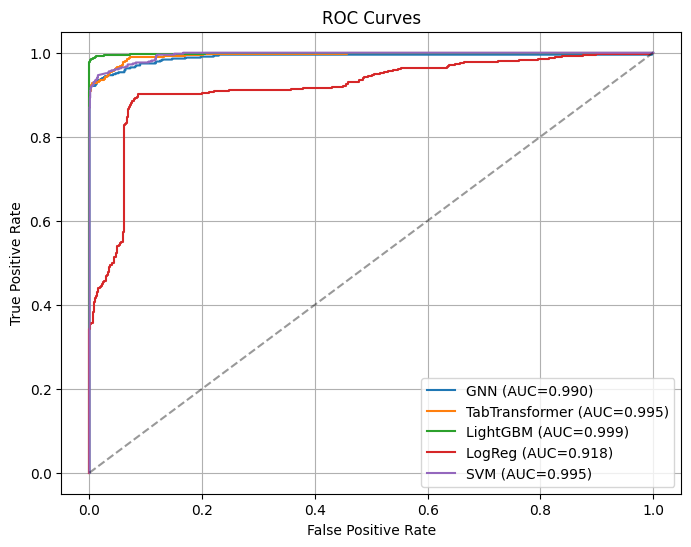

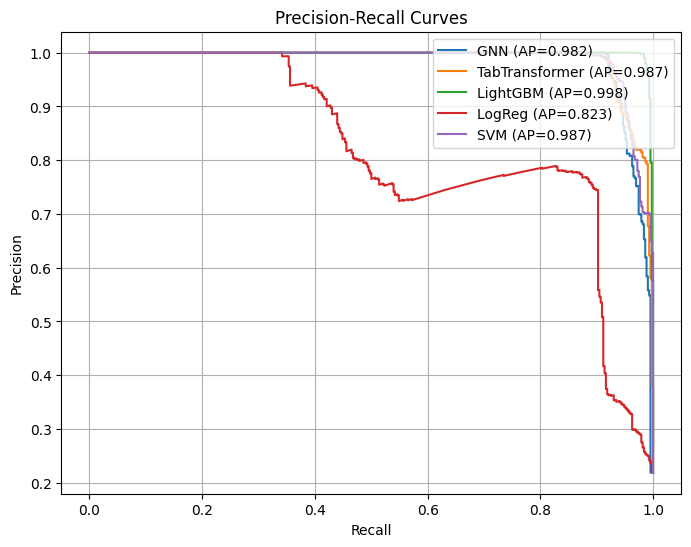

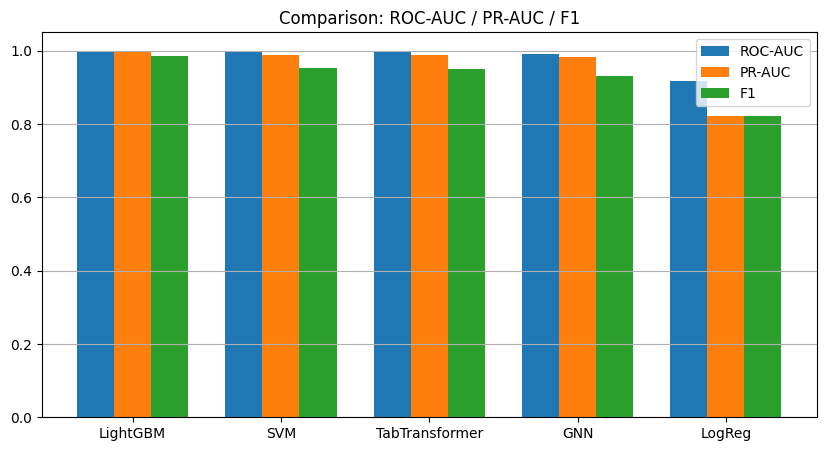

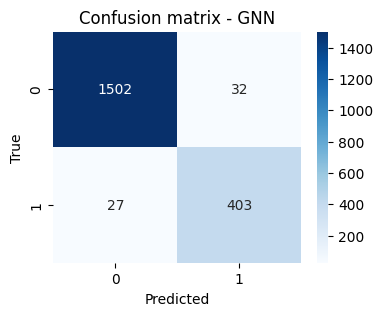

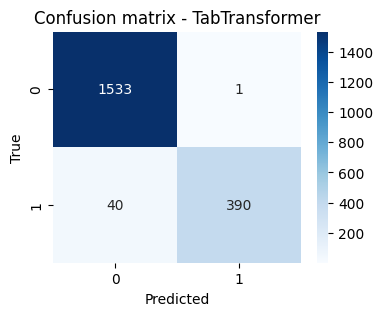

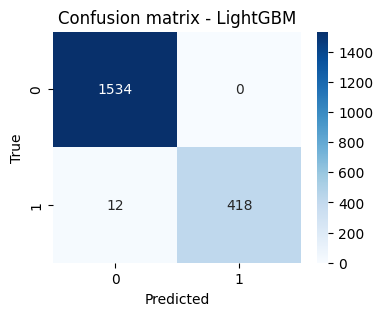

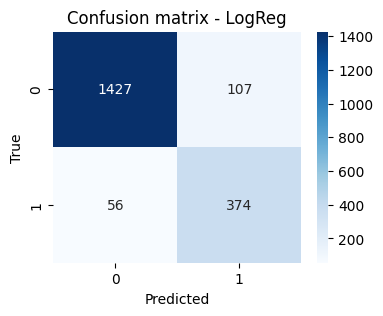

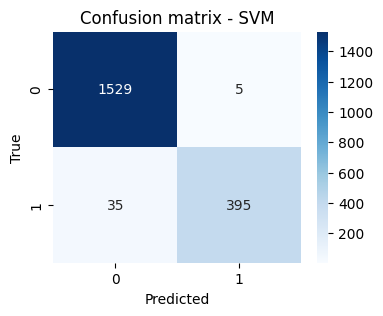

Saved ./artifacts\models_comparison_metrics.csv


In [77]:
# Robust final compare cell — explicit priorities + no file reuse
import os, numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns

ART = './artifacts'
assert os.path.isdir(ART), f"Artifacts dir not found: {ART}"

# Models we want to compare (order matters for priorities)
model_names = ['GNN', 'TabTransformer', 'LightGBM', 'LogReg', 'SVM']

# preferred canonical filenames for quick exact matching (if present)
canonical_map = {
    'GNN': 'gnn_test_probs.npy',
    'TabTransformer': 'tab_test_probs.npy',
    'LightGBM': 'lightgbm_test_probs.npy',   # prefer this name (your retrained file)
    'LogReg': 'logreg_test_probs.npy',
    'SVM': 'svm_test_probs.npy'
}

# fallback pattern tokens (in priority order) to search file names if canonical not present
pattern_map = {
    'GNN': ['gnn'],
    'TabTransformer': ['tabtransformer','tab_transformer','tab-transformer','tab'],
    'LightGBM': ['lightgbm','lightgbm','lgb','lgbm'],
    'LogReg': ['logreg','log_reg','logistic'],
    'SVM': ['svm']
}

# list all candidate files in artifacts that look like probability outputs
all_files = sorted([f for f in os.listdir(ART) if f.lower().endswith('.npy') and 'test' in f.lower()])
print("Candidate files:", all_files)

# load canonical y_test (fallback to any *_test_true.npy if y_test.npy missing)
y_true = None
y_true_path = os.path.join(ART, "y_test.npy")
if os.path.exists(y_true_path):
    y_true = np.load(y_true_path, allow_pickle=True)
else:
    # find any *_test_true.npy
    for f in all_files:
        if f.lower().endswith('_true.npy'):
            y_true = np.load(os.path.join(ART, f), allow_pickle=True)
            break
assert y_true is not None, "Could not find y_test.npy or any *_test_true.npy in artifacts"
n_y = len(y_true)
print("Loaded y_test length:", n_y)

# Helper to check candidate file suitability (numeric, 1-D probs, length matches y)
def check_candidate(path):
    try:
        arr = np.load(path, allow_pickle=True)
    except Exception:
        return None
    # convert to float array if possible
    try:
        af = np.asarray(arr, dtype=float).ravel()
    except Exception:
        return None
    # require 1-D of same length as y_true
    if af.ndim == 1 and af.shape[0] == n_y:
        return af
    return None

used_files = set()
results = {}

for model in model_names:
    chosen_file = None
    chosen_arr = None

    # 1) try canonical exact name first
    can = canonical_map.get(model)
    if can:
        p = os.path.join(ART, can)
        if os.path.exists(p) and can not in used_files:
            arr = check_candidate(p)
            if arr is not None:
                chosen_file = can
                chosen_arr = arr

    # 2) try pattern matches (priority order), skip already-used files
    if chosen_file is None:
        patterns = pattern_map.get(model, [model.lower()])
        for pat in patterns:
            # prefer files that contain both model token + 'prob' + 'test'
            candidates = [f for f in all_files if (pat in f.lower() and ('prob' in f.lower() or 'probs' in f.lower()) and 'test' in f.lower())]
            # try exact matches first, then looser matches
            if not candidates:
                candidates = [f for f in all_files if (pat in f.lower() and 'test' in f.lower())]
            # sort candidates to prefer shorter filenames (heuristic)
            candidates = sorted(candidates, key=lambda x: len(x))
            for cand in candidates:
                if cand in used_files:
                    continue
                arr = check_candidate(os.path.join(ART, cand))
                if arr is not None:
                    chosen_file = cand
                    chosen_arr = arr
                    break
            if chosen_file:
                break

    # 3) Final fallback: any remaining file that looks like a prob vector and isn't used
    if chosen_file is None:
        for cand in all_files:
            if cand in used_files:
                continue
            arr = check_candidate(os.path.join(ART, cand))
            if arr is not None:
                chosen_file = cand
                chosen_arr = arr
                break

    if chosen_file is None:
        print(f"[WARN] Could not find a suitable probs file for model {model} (skipping).")
        continue

    # Mark as used and store results
    used_files.add(chosen_file)
    # attempt to load preds file by replacing 'probs'->'preds' or searching for *_preds.npy with same model token
    preds = None
    preds_candidates = [
        chosen_file.replace('probs', 'preds'),
        chosen_file.replace('prob', 'preds')
    ]
    # also any *_preds that contains the same model token
    token = model.lower()
    preds_candidates += [f for f in all_files if token in f.lower() and 'pred' in f.lower()]
    for pc in preds_candidates:
        pc_path = os.path.join(ART, pc)
        if os.path.exists(pc_path):
            try:
                preds_arr = np.load(pc_path, allow_pickle=True)
                if len(preds_arr) == n_y:
                    preds = preds_arr
                    break
            except Exception:
                pass
    if preds is None:
        preds = (chosen_arr > 0.5).astype(int)

    print(f"Using probs file for {model}: {chosen_file}")
    results[model] = {'probs': chosen_arr, 'preds': preds}

print("\nModels discovered and loaded:", list(results.keys()))

# Build metrics DataFrame
rows = []
for name, vals in results.items():
    probs = vals['probs']; preds = vals['preds']
    auc_score = roc_auc_score(y_true, probs)
    pr_auc = average_precision_score(y_true, probs)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, preds, average='binary', zero_division=0)
    acc = (preds == y_true).mean()
    rows.append({'model': name, 'ROC-AUC': auc_score, 'PR-AUC': pr_auc, 'precision': prec, 'recall': rec, 'f1': f1, 'acc': acc})
df_metrics = pd.DataFrame(rows).sort_values('ROC-AUC', ascending=False).reset_index(drop=True)
print("\nFinal metrics:\n", df_metrics)

# Plots (ROC + PR + bars)
plt.figure(figsize=(8,6))
for name, vals in results.items():
    fpr, tpr, _ = roc_curve(y_true, vals['probs'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves'); plt.legend(loc='lower right'); plt.grid(True); plt.show()

plt.figure(figsize=(8,6))
for name, vals in results.items():
    pr, rc, _ = precision_recall_curve(y_true, vals['probs'])
    ap = average_precision_score(y_true, vals['probs'])
    plt.plot(rc, pr, label=f"{name} (AP={ap:.3f})")
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curves'); plt.legend(loc='upper right'); plt.grid(True); plt.show()

plt.figure(figsize=(10,5))
x = np.arange(len(df_metrics))
width = 0.25
plt.bar(x - width, df_metrics['ROC-AUC'], width, label='ROC-AUC')
plt.bar(x, df_metrics['PR-AUC'], width, label='PR-AUC')
plt.bar(x + width, df_metrics['f1'], width, label='F1')
plt.xticks(x, df_metrics['model']); plt.ylim(0,1.05); plt.title('Comparison: ROC-AUC / PR-AUC / F1'); plt.legend(); plt.grid(axis='y'); plt.show()

for name, vals in results.items():
    cm = confusion_matrix(y_true, vals['preds'])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion matrix - {name}'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

# Save CSV
out_path = os.path.join(ART, "models_comparison_metrics.csv")
df_metrics.to_csv(out_path, index=False)
print("Saved", out_path)


In [78]:
leaks = [c for c in ['Unnamed: 0', 'Index'] if c in feature_cols]
print("Leaky columns present in feature_cols:", leaks)

# also check original df if available
if os.path.exists('/mnt/data/ethereum_raw.csv'):
    df = pd.read_csv('/mnt/data/ethereum_raw.csv', low_memory=False)
    print("Original df columns containing 'Unnamed' or 'Index':", [c for c in df.columns if 'Unnamed' in c or 'Index' in c])


Leaky columns present in feature_cols: []


In [79]:
# Confirm dropped leak and consistent columns
print('Unnamed: 0' in meta['feature_cols'])  # should print False
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


False
Shapes: (6674, 47) (1178, 47) (1964, 47)


In [80]:
# # Step 1: Check connection to local Ganache RPC
# from web3 import Web3
# import json, sys

# RPC = "http://127.0.0.1:8545"  # Ganache default
# w3 = Web3(Web3.HTTPProvider(RPC))

# print("Web3 connected:", w3.is_connected())
# if not w3.is_connected():
#     print("Failed to connect. Is Ganache running on http://127.0.0.1:8545 ?")
# else:
#     try:
#         # show chain id and first 5 accounts
#         chain_id = w3.eth.chain_id
#         accounts = w3.eth.accounts  # requires Ganache (auto-unlocked accounts)
#         print("Chain ID:", chain_id)
#         print("Accounts (first 5):")
#         for a in accounts[:5]:
#             print("  ", a)
#         print("\nYou can use these accounts for deploying/contracts in this notebook.")
#     except Exception as e:
#         print("Error reading chain info:", e)
#         raise


In [81]:
# # Quick send: from account 0 to account 1, 0.001 ETH (Ganache has unlocked accounts)
# from web3 import Web3
# w3 = Web3(Web3.HTTPProvider("http://127.0.0.1:8545"))

# acct_from = w3.eth.accounts[0]
# acct_to   = w3.eth.accounts[1]

# # Build & send a simple transaction (Ganache auto-signs unlocked accounts)
# tx = {
#     "from": acct_from,
#     "to": acct_to,
#     "value": w3.to_wei(0.001, "ether"),
#     "gas": 21000,
# }
# try:
#     tx_hash = w3.eth.send_transaction(tx)
#     receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
#     print("Tx sent. Hash:", tx_hash.hex())
#     print("Receipt status:", receipt.status)
# except Exception as e:
#     print("Transaction failed:", e)


In [82]:
import numpy as np, os
ART = "./artifacts"
X_train = np.load(os.path.join(ART, "X_train.npy")); X_val = np.load(os.path.join(ART, "X_val.npy")); X_test = np.load(os.path.join(ART, "X_test.npy"))
y_train = np.load(os.path.join(ART, "y_train.npy")); y_val = np.load(os.path.join(ART, "y_val.npy")); y_test = np.load(os.path.join(ART, "y_test.npy"))

# stacked order check
n_train, n_val, n_test = X_train.shape[0], X_val.shape[0], X_test.shape[0]
print("Split sizes (train,val,test):", n_train, n_val, n_test)

# If graph artifacts exist, check their node count and that addresses match
if os.path.exists(os.path.join(ART, "graph_artifacts.pt")):
    import torch
    art = torch.load(os.path.join(ART, "graph_artifacts.pt"))
    x_nodes = art['x'].cpu().numpy()
    addresses_graph = art.get('addresses', None)
    print("Graph nodes:", x_nodes.shape[0], "expected nodes (stacked):", n_train + n_val + n_test)
    if addresses_graph is not None:
        # address overlap check with saved address splits
        a_tr = np.load(os.path.join(ART, "addresses_train.npy"), allow_pickle=True)
        a_va = np.load(os.path.join(ART, "addresses_val.npy"), allow_pickle=True)
        a_te = np.load(os.path.join(ART, "addresses_test.npy"), allow_pickle=True)
        set_overlap = len(set(a_tr) & set(a_te))
        print("Train/Test address overlap (should be 0):", set_overlap)


Split sizes (train,val,test): 6674 1178 1964
Graph nodes: 9816 expected nodes (stacked): 9816
Train/Test address overlap (should be 0): 0


C:\Users\manis\AppData\Local\Temp\ipykernel_20216\1791476039.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(os.path.join(ART, "graph_artifacts.pt"))
